# Carte NODU 

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
def nettoyage_chaine_caracteres(s):
    s = s.lower()
    remplacements = {
        'é':'e',
        'è':'e',
        'ê':'e',
        'à':'a'
    }
    for char in remplacements.keys():
        s = s.replace(char,remplacements[char])
    return s

def calcul_NODU_CP(donnees_BNVD_CP, donnees_DU, CP):
    df_merge = donnees_DU.merge(donnees_BNVD_CP, on="substance")
    
    df_merge['NODU'] = df_merge['quantite_substance']/df_merge['2015']
    return df_merge.NODU.sum()

## Doses unitaires

In [3]:
fichier_DU = r'./donnees/utf 8 Annexe 5 arr t DU 27 avril 2017.csv'
donnees_DU = pd.read_csv(fichier_DU, sep=';', header=3, names=['substance','2011','2012','2013','2014','2015'], na_values='-',encoding='latin1')

for col in ['2011','2012','2013','2014','2015']:
    donnees_DU[col] = donnees_DU[col].str.replace(',','.').astype('float64')

for index, row in donnees_DU.iterrows():
    donnees_DU.at[index,'substance'] = nettoyage_chaine_caracteres(donnees_DU.at[index,'substance'])

## BNVD

In [4]:
chemin_donnees_bnvd = r'./donnees/bnvd/BNVD_2020_ACHAT_2019'

liste_fichiers = glob.glob(os.path.join(chemin_donnees_bnvd,'*'))
liste_fichiers_substance_CP = [x for x in liste_fichiers \
                               if 'CP_SUBSTANCE' in x \
                               and 'REUNION' not in x \
                               and 'MAYOTTE' not in x \
                               and 'GUADELOUPE' not in x \
                               and 'MAYOTTE' not in x \
                               and 'GUYANE' not in x \
                               and 'CORSE' not in x \
                               and 'MARTINIQUE' not in x \
                               and 'INDETERMINE' not in x]

## NODU par CP

In [5]:
NODU = pd.DataFrame(columns=['codes_postaux','NODU'])

for f in liste_fichiers_substance_CP:
    print(os.path.split(f)[-1])
    donnees_bnvd = pd.read_csv(f,sep=';', dtype={'amm':'str', 'quantite_substance':'float64', 'code_postal_acheteur':'str', 'substance':'str'}, na_values='nc')
    for index, row in donnees_bnvd.iterrows():
        # Cette étape est longue. Voir si on peut se contenter d'utiliser donnees_bnvd.substance.str.lower() qui doit etre plus efficace
        donnees_bnvd.at[index,'substance'] = nettoyage_chaine_caracteres(str(donnees_bnvd.at[index,'substance']))
    
    NODU_list = []
    CP_list = donnees_bnvd.code_postal_acheteur.unique()
    for CP in CP_list:
        donnees_BNVD_CP = donnees_bnvd[donnees_bnvd['code_postal_acheteur']==CP][['substance', 'quantite_substance']].groupby(by='substance').sum()
        NODU_list.append(calcul_NODU_CP(donnees_BNVD_CP, donnees_DU, CP))
    NODU = NODU.append(pd.DataFrame(data={'codes_postaux':CP_list,'NODU':NODU_list}))

NODU = NODU.groupby(by='codes_postaux').sum()

BNVD_2020_ACHAT_CP_SUBSTANCE_HAUTS DE FRANCE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_ILE DE FRANCE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_NORMANDIE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_BRETAGNE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_NOUVELLE AQUITAINE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_PAYS DE LA LOIRE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_AUVERGNE RHONE ALPES_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_CENTRE VAL DE LOIRE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_OCCITANIE_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_GRAND EST_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_PROVENCE ALPES COTE D AZUR_2019.csv
BNVD_2020_ACHAT_CP_SUBSTANCE_BOURGOGNE FRANCHE COMTE_2019.csv


## SAU par CP
A partir des données CRATer

In [6]:
# A partir des données CRATer pour l'instant
fichier_sau = r'../../crater-data-resultats/sau/2017/sau-communes.csv'
donnees_sau = pd.read_csv(fichier_sau, dtype={'insee':'str'}, sep=';')
donnees_sau['insee'] = 'C-' + donnees_sau['insee']

fichier_communes = r'../../crater-data-resultats/territoires/communes.csv'
donnees_communes = pd.read_csv(fichier_communes, dtype={'codes_postaux':'str'}, sep=';')

donnees_sau = donnees_sau.merge(donnees_communes)[['codes_postaux','sau_ha']].groupby(by='codes_postaux').sum()

NODU_complet = NODU.merge(donnees_sau, left_index=True, right_index=True)
#NODU_complet.fillna(0)
NODU_complet['NODU_normalise'] = NODU_complet['NODU'] / NODU_complet['sau_ha']

## Cartographie
Données geo des communes [ici](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/)

(6000000.0, 7200000.0)

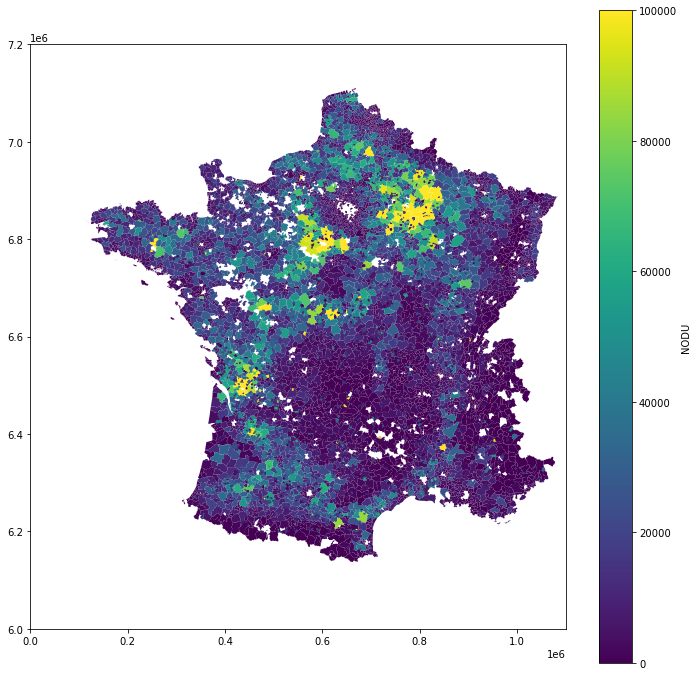

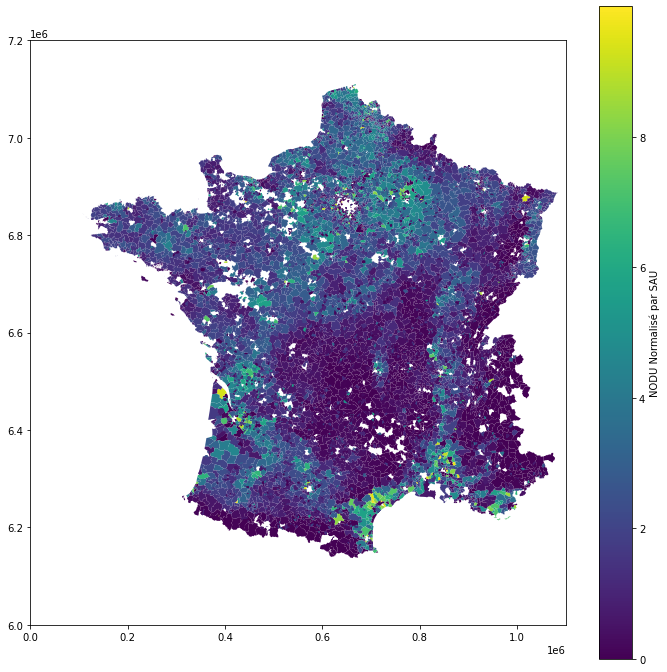

In [9]:
fichier_geojson = r'donnees/geojson/communes-20190101/communes-20190101.json'
donnees_geo_communes = gpd.read_file(fichier_geojson)
donnees_geo_communes['insee'] = 'C-' + donnees_geo_communes['insee']
donnees_geo_communes = donnees_geo_communes.merge(donnees_communes)

donnees_geo_CP = donnees_geo_communes.dissolve(by='codes_postaux')
donnees_geo_NODU = donnees_geo_CP.merge(NODU_complet, how='outer', left_index=True, right_index=True)

donnees_geo_NODU = donnees_geo_NODU.to_crs(2154)
donnees_geo_CP = donnees_geo_CP.to_crs(2154)
donnees_geo_communes = donnees_geo_communes.to_crs(2154)

plt.close('all')

donnees_geo_NODU['NODU'].values[donnees_geo_NODU['NODU'].values > 100000] = 100000
ax2 = donnees_geo_NODU.plot('NODU', legend=True, legend_kwds={'label': 'NODU'}, figsize=(12, 12))
ax2.set_xlim([0,1.1e6])
ax2.set_ylim([6e6,7.2e6])

# On met un seuil à 10 comme dans l'article du monde. Evite la divergence liées aux SAU nulles ou très faibles
# On doit pouvoir un peu mieux, en mettant le seuil à la fois sur les SAU (1ha ?) et sur les NODU
donnees_geo_NODU['NODU_normalise'].values[donnees_geo_NODU['NODU_normalise'].values > 10] = 10
ax3 = donnees_geo_NODU.plot('NODU_normalise', legend=True, legend_kwds={'label': 'NODU Normalisé par SAU'}, figsize=(12, 12))
ax3.set_xlim([0,1.1e6])
ax3.set_ylim([6e6,7.2e6])